#### EDA and initial model building/testing

#### Loading data

In [1]:
import numpy as np
import scipy.sparse as sp
import json
import random
import torch
import dgl
import matplotlib.pyplot as plt

random_seed = 12

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
dgl.seed(random_seed)


# Load the data
adjacency_matrix = sp.load_npz("adj.npz") # Defines graph architecture
feature_matrix = np.load("features.npy") # Defines nodes feature
labels = np.load("labels.npy") 

# Load the indices
with open("splits.json", "r") as f:
    data_splits = json.load(f)

train_indices0 = data_splits["idx_train"]
test_indices = data_splits["idx_test"]

#### Building graph and maksking data for train, test, and validation sets.

In [2]:
import dgl
import torch
from sklearn.model_selection import train_test_split

# Create a DGL graph from the adjacency matrix
graph = dgl.from_scipy(adjacency_matrix) 

# Convert the feature matrix to a PyTorch tensor
feature_matrix_tensor = torch.tensor(feature_matrix, dtype=torch.float32) 

# Split the data into training, validation (Best approach)
# train_indices, val_indices0 = train_test_split(train_indices0, test_size=0.5, random_state=42)
# val_indices, val_indicesf  = train_test_split(val_indices0, test_size=0.5, random_state=42)

# First, create a train-validation-test split from train_indices0
train_indices, val_indices0 = train_test_split(train_indices0, test_size=0.5, stratify=labels, random_state=42)

# Now, split the remaining data into validation and final validation sets
val_indices, val_indicesf = train_test_split(val_indices0, test_size=0.5, random_state=42)


# Create masks for the training, validation, and testing sets, for efficient and optimized filtering
train_mask = torch.zeros(graph.number_of_nodes(), dtype=torch.bool)
val_mask = torch.zeros(graph.number_of_nodes(), dtype=torch.bool)
val_maskf = torch.zeros(graph.number_of_nodes(), dtype=torch.bool)
test_mask = torch.zeros(graph.number_of_nodes(), dtype=torch.bool)

train_mask[train_indices] = True
val_mask[val_indices] = True
val_maskf[val_indicesf] = True
test_mask[test_indices] = True

# Add the masks to the graph
graph.ndata['train_mask'] = train_mask
graph.ndata['val_mask'] = val_mask
graph.ndata['val_maskf'] = val_maskf
graph.ndata['test_mask'] = test_mask


# Initialize a tensor to store labels for all nodes
labels_tensor = torch.full((graph.number_of_nodes(),), -1, dtype=torch.long)

# Assign the known labels to the corresponding nodes in the labels_tensor
labels_tensor[train_indices0] = torch.tensor(labels, dtype=torch.long)
labels_tensor

# Add labels to the graph nodes
graph.ndata['label'] = labels_tensor
graph.ndata['features'] = feature_matrix_tensor
print("Graph info:", graph)

Graph info: Graph(num_nodes=2480, num_edges=10100,
      ndata_schemes={'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'val_maskf': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'label': Scheme(shape=(), dtype=torch.int64), 'features': Scheme(shape=(1390,), dtype=torch.float32)}
      edata_schemes={})


# EDA

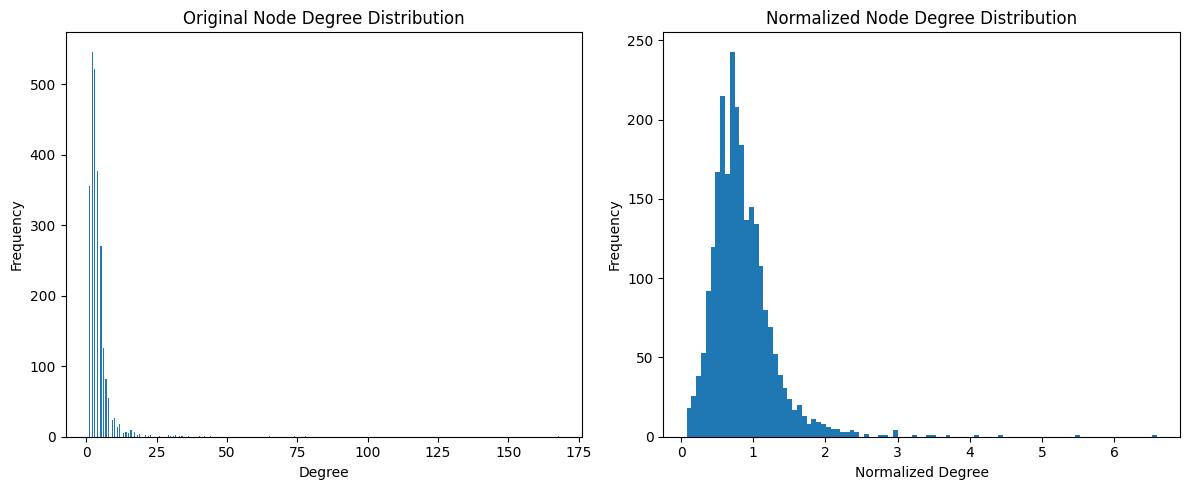

In [3]:
# Degree distribution graph, degree normalization might be useful while developing the GCN

import networkx as nx
import matplotlib.pyplot as plt

g_nx = graph.to_networkx().to_undirected()
degree_sequence = [d for n, d in g_nx.degree()]

# Calculate the degree matrix
degree = np.array(degree_sequence)
degree_sqrt_inv = 1 / np.sqrt(degree)

# Calculate the normalized adjacency matrix
A_nx = nx.to_numpy_array(g_nx)
A_normalized = A_nx * degree_sqrt_inv[:, None] * degree_sqrt_inv[None, :]

# Calculate the normalized degree sequence
degree_normalized_sequence = np.sum(A_normalized, axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Original degree distribution
ax1.hist(degree_sequence, bins='auto')
ax1.set_xlabel('Degree')
ax1.set_ylabel('Frequency')
ax1.set_title('Original Node Degree Distribution')

# Normalized degree distribution
ax2.hist(degree_normalized_sequence, bins='auto')
ax2.set_xlabel('Normalized Degree')
ax2.set_ylabel('Frequency')
ax2.set_title('Normalized Node Degree Distribution')

plt.tight_layout()
plt.show()


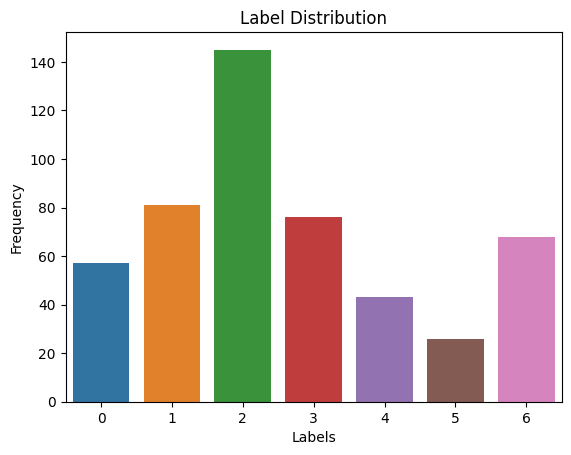

In [3]:
# Check for class imbalance. Good to pass class weights while training.
import seaborn as sns

label_counts = np.bincount(labels)
sns.barplot(x=np.unique(labels), y=label_counts)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Label Distribution')
plt.show()

class_weights = torch.tensor(label_counts.sum() / (len(label_counts) * label_counts), dtype=torch.float32)

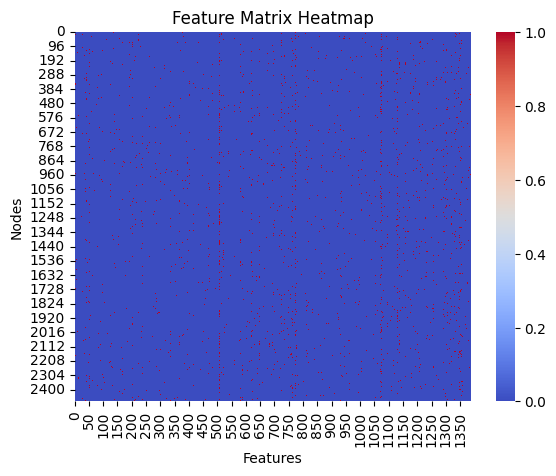

In [5]:
# As data is binary, this helps in understanding imp features and important nodes in the data.
sns.heatmap(feature_matrix, cmap='coolwarm', cbar=True)
plt.xlabel('Features')
plt.ylabel('Nodes')
plt.title('Feature Matrix Heatmap')
plt.show()


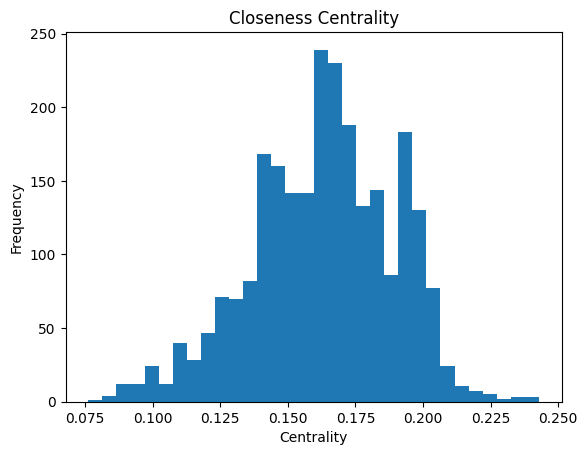

In [6]:
# Measure of centralities in the distribution, can be added as additional feature engineered parameter in the feature matrix

# Closeness centrality
closeness_centrality = nx.closeness_centrality(g_nx)

# # Plot the centralities
centralities = [closeness_centrality]
titles = ['Closeness Centrality']

for i, centrality in enumerate(centralities):
    plt.figure(i)
    plt.hist(list(centrality.values()), bins='auto')
    plt.title(titles[i])
    plt.xlabel('Centrality')
    plt.ylabel('Frequency')
    plt.show()


In [14]:
# Analyzing hub nodes and classes of their neighbours (nodes with high connectivity)

degree_centrality = nx.degree_centrality(g_nx)

hub_nodes = [node for node, centrality in degree_centrality.items() if centrality >= 0.01]

hub_node_labels = [labels_tensor[node] for node in hub_nodes]

hub_neighbors_labels = []

for hub_node in hub_nodes:
    neighbors = list(g_nx.neighbors(hub_node))
    neighbor_labels = [labels_tensor[neighbor] for neighbor in neighbors]
    hub_neighbors_labels.append(neighbor_labels)


NameError: name 'nx' is not defined

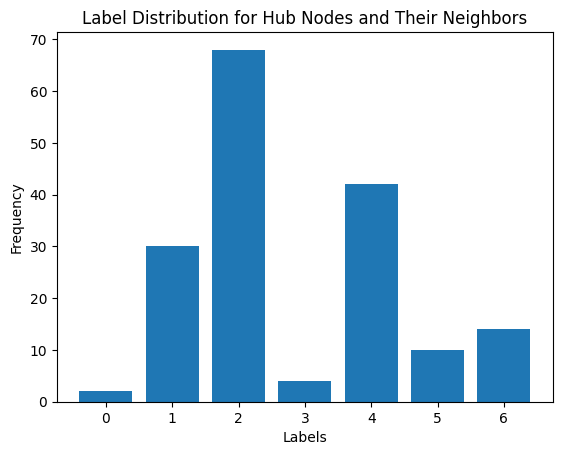

In [8]:

all_labels = np.concatenate([hub_node_labels] + hub_neighbors_labels)
all_labels = [label for label in all_labels if label >= 0]

unique_labels = np.unique(all_labels)
label_counts = np.bincount(all_labels)
plt.bar(unique_labels, label_counts)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Label Distribution for Hub Nodes and Their Neighbors')
plt.show()


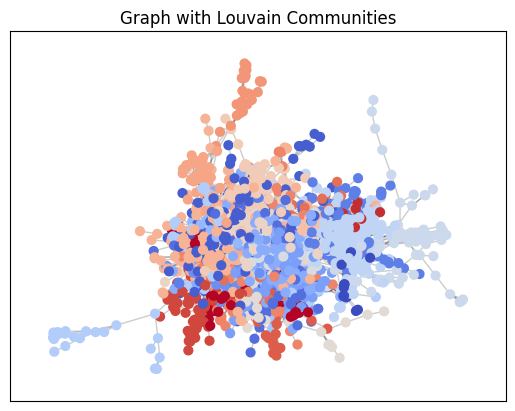

In [9]:
import community as community_louvain

# Louvain community detection
partition = community_louvain.best_partition(g_nx)

# Visualize the graph with nodes colored according to their communities
pos = nx.spring_layout(g_nx)
cmap =  plt.get_cmap('coolwarm')
nx.draw_networkx_nodes(g_nx, pos, partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(g_nx, pos, alpha=0.2)
plt.title('Graph with Louvain Communities')
plt.show()


In [6]:
# Dimensionality reduction visualization
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
reduced_features_pca = pca.fit_transform(feature_matrix)
tsne = TSNE(n_components=2)
reduced_features_tsne = tsne.fit_transform(feature_matrix)

# converting tensor to labels
labels_updated = np.array(labels_tensor)
# labels


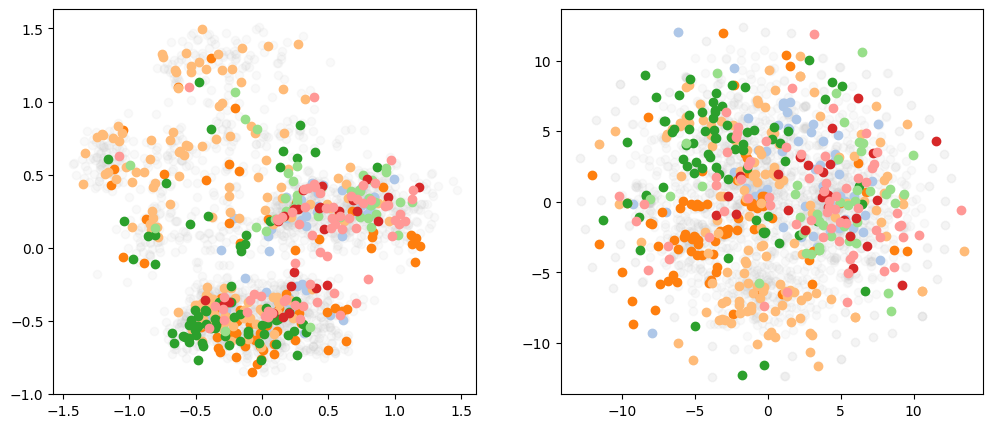

In [5]:
# Plot the reduced features with PCA and t-SNE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot PCA with labels
unique_labels = np.unique(labels_updated)
colors = [plt.cm.tab20((i+1) % 20) for i in range(len(unique_labels) - 1)]
colors.insert(0, (0.8, 0.8, 0.8, 0.3))  # set color for -1 labels
legend_handles = []
for i, label in enumerate(unique_labels):
    if label == -1:
        alpha = 0.1  # reduce opacity for -1 labels
    else:
        alpha = 1.0
    color = colors[i]
    mask = (labels_updated == label) 
    ax1.scatter(reduced_features_pca[mask, 0], reduced_features_pca[mask, 1], 
                color=color, alpha=alpha)
    handle = ax1.scatter([], [], color=color, label=label)
    legend_handles.append(handle)

    if label == -1:
        alpha = 0.1  # reduce opacity for -1 labels
    else:
        alpha = 1.0
    color = colors[i]
    mask = (labels_updated == label) 
    ax2.scatter(reduced_features_tsne[mask, 0], reduced_features_tsne[mask, 1], 
                color=color, alpha=alpha)
    handle = ax2.scatter([], [], color=color, label=label)
    legend_handles.append(handle)


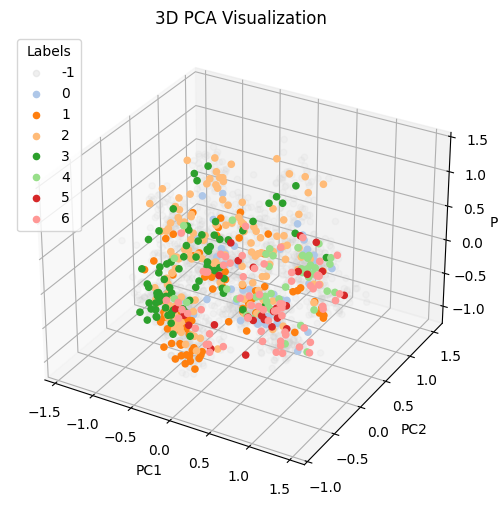

In [7]:
# In 3 D
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
reduced_features_pca = pca.fit_transform(feature_matrix)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

unique_labels = np.unique(labels_updated)
colors = [plt.cm.tab20((i + 1) % 20) for i in range(len(unique_labels) - 1)]
colors.insert(0, (0.8, 0.8, 0.8, 0.3))  # set color for -1 labels
legend_handles = []

for i, label in enumerate(unique_labels):
    if label == -1:
        alpha = 0.1  # reduce opacity for -1 labels
    else:
        alpha = 1.0
    color = colors[i]
    mask = (labels_updated == label)
    ax.scatter(reduced_features_pca[mask, 0], reduced_features_pca[mask, 1], reduced_features_pca[mask, 2],
               color=color, alpha=alpha)
    handle = ax.scatter([], [], [], color=color, label=label)
    legend_handles.append(handle)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA Visualization')
plt.legend(handles=legend_handles, loc='upper left', title="Labels")
plt.show()



In [12]:
import plotly.graph_objs as go
import plotly.express as px

# PCA
fig = go.Figure()

unique_labels = np.unique(labels_updated)
colors = px.colors.qualitative.Plotly

for i, label in enumerate(unique_labels):
    mask = (labels_updated == label) & (labels_updated != -1)
    fig.add_trace(go.Scatter3d(
        x=reduced_features_pca[mask, 0],
        y=reduced_features_pca[mask, 1],
        z=reduced_features_pca[mask, 2],
        mode='markers',
        marker=dict(size=6, color=colors[i % len(colors)], opacity=0.7),
        name=f'Label {label}'
    ))

fig.update_layout(title='3D PCA Visualization',
                  scene=dict(xaxis_title='PC1',
                             yaxis_title='PC2',
                             zaxis_title='PC3'))


In [62]:
import numpy as np
import scipy.sparse as sp
import json
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

np.random.seed(123)

# Load the data
adjacency_matrix = sp.load_npz("adj.npz")  # Defines graph architecture
feature_matrix = np.load("features.npy")  # Defines nodes feature
labels = np.load("labels.npy")

# Load the indices
with open("splits.json", "r") as f:
    data_splits = json.load(f)

train_indices0 = data_splits["idx_train"]
test_indices = data_splits["idx_test"]

# Split the initial train_indices into train and validation sets
train_indices, val_indices = train_test_split(train_indices0, test_size=0.2, random_state=42)

# Split the dataset into train, validation, and test sets
X_train, y_train = feature_matrix[train_indices], labels[train_indices]
X_val, y_val = feature_matrix[val_indices], labels[val_indices]
X_test = feature_matrix[test_indices]

# Train the SVM classifier
svm = SVC()
svm.fit(X_train, y_train)

# Train the Random Forest classifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Make predictions with the individual classifiers on the validation set
svm_pred = svm.predict(X_val)
rf_pred = rf.predict(X_val)

# Ensemble the predictions using a majority vote
ensemble_pred = np.array([np.argmax(np.bincount(predictions)) for predictions in zip(svm_pred, rf_pred)])

# Calculate the accuracy of the ensemble classifier on the validation set
ensemble_accuracy = accuracy_score(y_val, ensemble_pred)
print(f"Ensemble accuracy on validation set: {ensemble_accuracy:.4f}")

# Make predictions with the ensemble classifier on the test set (without labels)
test_predictions = np.array([np.argmax(np.bincount(predictions)) for predictions in zip(svm.predict(X_test), rf.predict(X_test))])


IndexError: index 2103 is out of bounds for axis 0 with size 496

In [4]:
# # Normalize degree sequence
# degree_normalized_sequence = degree_normalized_sequence.reshape(-1, 1)

# # Calculate closeness centrality
# closeness_centrality = nx.closeness_centrality(g_nx)

# # Convert closeness centrality dictionary to numpy array
# closeness_centrality_array = np.array(list(closeness_centrality.values())).reshape(-1, 1)

# # Concatenate the normalized degree sequence and closeness centrality to the original feature matrix
# new_feature_matrix = np.concatenate((feature_matrix, degree_normalized_sequence, closeness_centrality_array), axis=1)

# # Concatenate the PCA components to the original feature matrix
# new_feature_matrix1 = np.concatenate((new_feature_matrix, reduced_features_pca), axis=1)

# # Convert the new feature matrix to a PyTorch tensor
# new_feature_matrix_tensor = torch.tensor(new_feature_matrix1, dtype=torch.float32)

# # Add the new features to the graph
# graph.ndata['features'] = new_feature_matrix_tensor
# graph.ndata['features'] = feature_matrix_tensor


In [14]:
print("Graph info:", graph)

Graph info: Graph(num_nodes=2480, num_edges=10100,
      ndata_schemes={'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'label': Scheme(shape=(), dtype=torch.int64), 'features': Scheme(shape=(1395,), dtype=torch.float32)}
      edata_schemes={})


In [4]:
# Soumya first
import torch.nn as nn
import torch.nn.functional as F
import dgl.nn as dglnn

class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_size, activation=F.relu)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = dglnn.GraphConv(hidden_size, num_classes)
        self.bn2 = nn.BatchNorm1d(num_classes)
        

    def forward(self, graph, inputs):
        h = self.conv1(graph, inputs)
        h = self.bn1(h)
        h = self.dropout1(h)
        h = self.conv2(graph, h)
        h = self.bn2(h)
        return h

# # Define the model, loss, and optimizer
in_feats = graph.ndata['features'].shape[1]
num_classes = len(np.unique(labels))

# in_feats = graph.ndata['features'].shape[1]
# hidden_size = 65
# num_classes = len(np.unique(labels))
# dropout = 0.54
# model1 = GCN(in_feats, hidden_size, num_classes, dropout)
# loss_function = nn.CrossEntropyLoss(weight= class_weights)
# optimizer = torch.optim.Adam(model1.parameters(), lr=0.1, weight_decay = 1e-04)

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import dgl.nn as dglnn
import random



class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_size, activation=F.relu)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout1 = nn.Dropout(dropout)
        
        self.conv2 = dglnn.GraphConv(hidden_size, hidden_size, activation=F.relu)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(dropout)
        
        self.conv3 = dglnn.GraphConv(hidden_size, num_classes)
        self.bn3 = nn.BatchNorm1d(num_classes)

    def forward(self, graph, inputs):
        h = self.conv1(graph, inputs)
        h = self.bn1(h)
        h = self.dropout1(h)
        
        h2 = self.conv2(graph, h)
        h2 = self.bn2(h2)
        h2 = self.dropout2(h2)
        
        h = h + h2  # Residual connection
        
        h = self.conv3(graph, h)
        h = self.bn3(h)
        return h

# # Define the model, loss, and optimizer
in_feats = graph.ndata['features'].shape[1]
num_classes = len(np.unique(labels))


In [37]:
class GAT(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, num_heads, dropout=0.5):
        super(GAT, self).__init__()
        self.layer1 = dglnn.GATConv(in_feats, hidden_size, num_heads=num_heads, activation=F.relu, dropout=dropout)
        self.layer2 = dglnn.GATConv(hidden_size * num_heads, hidden_size, num_heads=num_heads, activation=F.relu, dropout=dropout)
        self.layer3 = dglnn.GATConv(hidden_size * num_heads, num_classes, num_heads=1, activation=None, dropout=dropout)

    def forward(self, graph, inputs):
        h = self.layer1(graph, inputs)
        h = h.view(h.shape[0], -1)  # Flatten the output
        h = F.dropout(h, training=self.training)

        h = self.layer2(graph, h)
        h = h.view(h.shape[0], -1)  # Flatten the output
        h = F.dropout(h, training=self.training)

        h = self.layer3(graph, h)
        h = h.squeeze(1)
        return h


In [ ]:
class ChebNet(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, k, dropout=0.5):
        super(ChebNet, self).__init__()
        self.layer1 = dglnn.ChebConv(in_feats, hidden_size, k, activation=F.relu)
        self.layer2 = dglnn.ChebConv(hidden_size, hidden_size, k, activation=F.relu)
        self.layer3 = dglnn.ChebConv(hidden_size, num_classes, k)

        self.dropout = nn.Dropout(dropout)

    def forward(self, graph, inputs):
        h = self.layer1(graph, inputs)
        h = self.dropout(h)

        h = self.layer2(graph, h)
        h = self.dropout(h)

        h = self.layer3(graph, h)
        return h


In [5]:
def train_evaluate(hyperparams, graph, in_feats, num_classes, train_mask, val_mask, weights):
    hidden_size = hyperparams['hidden_size']
    learning_rate = hyperparams['learning_rate']
    weight_decay = hyperparams['weight_decay']
    optimizer_name = hyperparams['optimizer']
    dropout = hyperparams['dropout']

    model = GCN(in_feats, hidden_size, num_classes, dropout)
    loss_function = nn.CrossEntropyLoss(weights)

    if optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Training loop and early stopping
    num_epochs = 20
    patience = 3
    best_val_accuracy = -1
    best_model_state = None
    num_epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        logits = model(graph, graph.ndata['features'])
        loss = loss_function(logits[train_mask], graph.ndata['label'][train_mask])

        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            logits = model(graph, graph.ndata['features'])
            train_accuracy = (logits[train_mask].argmax(dim=1) == graph.ndata['label'][train_mask]).float().mean().item()
            val_accuracy = (logits[val_mask].argmax(dim=1) == graph.ndata['label'][val_mask]).float().mean().item()

        print(f"Epoch {epoch + 1}, Loss: {loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Early stopping
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = model
            num_epochs_without_improvement = 0
        else:
            num_epochs_without_improvement += 1
            if num_epochs_without_improvement >= patience:
                print("Early stopping")
                break
    
    
    return best_val_accuracy, best_model

train_indicescv = train_indices + val_indices

def train_evaluateCV(hyperparams, graph, in_feats, num_classes, kf, train_indicescv, weights):
    avg_val_accuracy = 0

    for train_idx, val_idx in kf.split(train_indicescv):
        train_mask = torch.zeros(graph.number_of_nodes(), dtype=torch.bool)
        val_mask = torch.zeros(graph.number_of_nodes(), dtype=torch.bool)

        train_mask[torch.tensor(train_indicescv)[train_idx]] = True
        val_mask[torch.tensor(train_indicescv)[val_idx]] = True

        graph.ndata['train_mask'] = train_mask
        graph.ndata['val_mask'] = val_mask

        val_accuracy, _ = train_evaluate(hyperparams, graph, in_feats, num_classes, train_mask, val_mask, weights)
        avg_val_accuracy += val_accuracy

    avg_val_accuracy /= kf.get_n_splits()

    return avg_val_accuracy


In [6]:
# Randomized Search for the parameters
from sklearn.model_selection import ParameterSampler
from sklearn.model_selection import KFold

param_dist = {
    'learning_rate': [0.001, 0.01, 0.1],
    'weight_decay': [1e-5, 1e-4, 1e-3],
    'hidden_size': [32, 64, 128],
    'optimizer': ['Adam', 'SGD', 'RMSprop'],
    'dropout': [0.0, 0.25, 0.5, 0.75]
}

n_iter = 30  # Number of iterations for the random search

# Cross-validation settings
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform random search
best_hyperparams = None
best_avg_val_accuracy = -1
for hyperparams in ParameterSampler(param_dist, n_iter):
    print(f"Training with hyperparameters: {hyperparams}")

    avg_val_accuracy = train_evaluateCV(hyperparams, graph, in_feats, num_classes, kf, train_indicescv, class_weights)
    print(f"Average validation accuracy: {avg_val_accuracy:.4f}")

    if avg_val_accuracy > best_avg_val_accuracy:
        best_avg_val_accuracy = avg_val_accuracy
        best_hyperparams = hyperparams

print(f"Best hyperparameters: {best_hyperparams}")
print(f"Best average validation accuracy: {best_avg_val_accuracy:.4f}")

Training with hyperparameters: {'weight_decay': 0.0001, 'optimizer': 'Adam', 'learning_rate': 0.001, 'hidden_size': 32, 'dropout': 0.0}
Epoch 1, Loss: 2.3327, Train Accuracy: 0.1518, Val Accuracy: 0.0769
Epoch 2, Loss: 1.9751, Train Accuracy: 0.3113, Val Accuracy: 0.1538
Epoch 3, Loss: 1.6744, Train Accuracy: 0.4358, Val Accuracy: 0.2000
Epoch 4, Loss: 1.4280, Train Accuracy: 0.5486, Val Accuracy: 0.2462
Epoch 5, Loss: 1.2293, Train Accuracy: 0.6304, Val Accuracy: 0.3692


c:\Users\Aditya\anaconda3\envs\gnn\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 6, Loss: 1.0709, Train Accuracy: 0.7160, Val Accuracy: 0.3846
Epoch 7, Loss: 0.9467, Train Accuracy: 0.7704, Val Accuracy: 0.4308
Epoch 8, Loss: 0.8487, Train Accuracy: 0.7977, Val Accuracy: 0.4769
Epoch 9, Loss: 0.7714, Train Accuracy: 0.8054, Val Accuracy: 0.4923
Epoch 10, Loss: 0.7098, Train Accuracy: 0.8249, Val Accuracy: 0.5231
Epoch 11, Loss: 0.6597, Train Accuracy: 0.8366, Val Accuracy: 0.5385
Epoch 12, Loss: 0.6174, Train Accuracy: 0.8638, Val Accuracy: 0.5846
Epoch 13, Loss: 0.5812, Train Accuracy: 0.8872, Val Accuracy: 0.5846
Epoch 14, Loss: 0.5499, Train Accuracy: 0.9144, Val Accuracy: 0.5692
Epoch 15, Loss: 0.5224, Train Accuracy: 0.9300, Val Accuracy: 0.6000
Epoch 16, Loss: 0.4978, Train Accuracy: 0.9416, Val Accuracy: 0.6154
Epoch 17, Loss: 0.4755, Train Accuracy: 0.9416, Val Accuracy: 0.6462
Epoch 18, Loss: 0.4552, Train Accuracy: 0.9416, Val Accuracy: 0.6615
Epoch 19, Loss: 0.4365, Train Accuracy: 0.9494, Val Accuracy: 0.6615
Epoch 20, Loss: 0.4190, Train Accuracy

In [7]:
# Cross-validation with the best hyperparameters
from sklearn.model_selection import KFold

# Cross-validation settings
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# train_indices0 = np.array(train_indices0)

avg_val_accuracy = 0
fold_count = 1
for train_idx, val_idx in kf.split(train_indicescv):
    train_mask = torch.zeros(graph.number_of_nodes(), dtype=torch.bool)
    val_mask = torch.zeros(graph.number_of_nodes(), dtype=torch.bool)

    train_mask[torch.tensor(train_indicescv)[train_idx]] = True
    val_mask[torch.tensor(train_indicescv)[val_idx]] = True

    graph.ndata['train_mask'] = train_mask
    graph.ndata['val_mask'] = val_mask

    print(f"Training fold {fold_count}")
    val_accuracy, best_model_fold = train_evaluate(best_hyperparams, graph, in_feats, num_classes, train_mask, val_mask, class_weights)
    avg_val_accuracy += val_accuracy
    fold_count += 1

avg_val_accuracy /= num_folds
print(f"Average validation accuracy: {avg_val_accuracy:.4f}")

Training fold 1
Epoch 1, Loss: 2.3742, Train Accuracy: 0.1868, Val Accuracy: 0.1231
Epoch 2, Loss: 2.2755, Train Accuracy: 0.5175, Val Accuracy: 0.5538
Epoch 3, Loss: 1.2555, Train Accuracy: 0.6304, Val Accuracy: 0.5846
Epoch 4, Loss: 0.7243, Train Accuracy: 0.8599, Val Accuracy: 0.7538
Epoch 5, Loss: 0.4961, Train Accuracy: 0.9261, Val Accuracy: 0.8462
Epoch 6, Loss: 0.3410, Train Accuracy: 0.9339, Val Accuracy: 0.8462
Epoch 7, Loss: 0.2699, Train Accuracy: 0.9377, Val Accuracy: 0.8462
Epoch 8, Loss: 0.2395, Train Accuracy: 0.9455, Val Accuracy: 0.8154
Early stopping
Training fold 2
Epoch 1, Loss: 2.2904, Train Accuracy: 0.1868, Val Accuracy: 0.1692
Epoch 2, Loss: 2.3291, Train Accuracy: 0.7121, Val Accuracy: 0.6769
Epoch 3, Loss: 1.0193, Train Accuracy: 0.8677, Val Accuracy: 0.7692
Epoch 4, Loss: 0.6297, Train Accuracy: 0.9183, Val Accuracy: 0.7077
Epoch 5, Loss: 0.3826, Train Accuracy: 0.9533, Val Accuracy: 0.7538
Epoch 6, Loss: 0.2842, Train Accuracy: 0.9767, Val Accuracy: 0.7692
E

In [8]:
best_model_fold.eval()
with torch.no_grad():
    logits = best_model_fold(graph, graph.ndata['features'])
    val_accuracyb = (logits[val_maskf].argmax(dim=1) == graph.ndata['label'][val_maskf]).float().mean().item()

print(val_accuracyb)


0.8103448152542114


tensor([3, 0, 2, 1, 6, 2, 4, 2, 4, 0, 0, 5, 2, 0, 0, 3, 3, 2, 4, 2, 3, 4, 6, 2,
        5, 0, 0, 3, 2, 0, 4, 1, 2, 5, 2, 1, 1, 1, 2, 3, 1, 2, 2, 3, 2, 6, 3, 6,
        2, 2, 3, 3, 1, 6, 5, 1, 3, 2, 2, 4, 3, 2, 0, 0, 6, 2, 2, 1, 2, 2, 2, 4,
        2, 1, 2, 6, 4, 4, 4, 1, 3, 2, 6, 2, 3, 2, 3, 2, 5, 4, 2, 3, 3, 1, 1, 6,
        5, 3, 6, 3, 3, 3, 1, 1, 0, 5, 1, 6, 1, 3, 3, 1, 2, 4, 3, 6, 6, 2, 4, 1,
        2, 2, 5, 6])

In [9]:

# Predict labels for all nodes
best_model_fold.eval()
with torch.no_grad():
    test_logits = best_model_fold(graph, graph.ndata['features'])
    test_predictions = test_logits[test_mask].argmax(dim=1).numpy()

# Save predictions to a file
# with open("submissiontest.txt", "w") as submission_file:
#     for prediction in test_predictions:
#         submission_file.write(str(prediction) + "\n")

# print("Predictions saved to submission.txt")

In [10]:
test_predictions

array([5, 2, 0, ..., 1, 2, 6], dtype=int64)

In [13]:
logits[val_maskf].argmax(dim=1)

<function Tensor.size>

In [15]:
graph.ndata['label'][val_maskf]

tensor([3, 0, 2, 1, 6, 4, 4, 2, 4, 0, 0, 6, 2, 0, 0, 3, 3, 2, 4, 2, 3, 4, 6, 2,
        6, 0, 0, 3, 5, 0, 4, 1, 2, 5, 1, 1, 1, 1, 2, 3, 1, 2, 2, 6, 2, 6, 3, 4,
        2, 2, 3, 3, 1, 6, 5, 1, 3, 6, 2, 4, 3, 2, 0, 0, 6, 2, 0, 1, 2, 2, 2, 4,
        2, 1, 6, 6, 4, 4, 2, 1, 3, 2, 6, 2, 3, 4, 3, 2, 5, 4, 2, 3, 3, 1, 1, 6,
        5, 3, 2, 3, 3, 2, 1, 1, 0, 0, 1, 6, 1, 3, 3, 1, 2, 4, 6, 6, 6, 2, 4, 1,
        2, 2, 0, 6])

In [16]:
labels

AttributeError: 'numpy.ndarray' object has no attribute 'indices'

In [10]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Assuming the length of the main data frame is `num_samples`
num_samples = len(feature_matrix)

# Create an array with the same length as the main data frame, filled with -1
new_labels_array = np.full(num_samples, -1, dtype=np.int8)

# Assign the labels to the corresponding indices in train_indices0
for i, index in enumerate(train_indices0):
    new_labels_array[index] = labels[i]

# Get the train_indices as a boolean mask
train_indices_mask = new_labels_array != -1

# Extract features and labels for the training dataset
train_features = feature_matrix[train_indices_mask]
train_labels = new_labels_array[train_indices_mask]

# Apply PCA with 85% variance coverage
pca = PCA(n_components=0.85)
pca_train_features = pca.fit_transform(train_features)
pca_feature_matrix = pca.transform(feature_matrix)

# Grid search for the best hyperparameters
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}

svc = SVC()
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(pca_train_features, train_labels)

print("Best hyperparameters:", grid_search.best_params_)
print("Best average validation accuracy:", grid_search.best_score_)

# Train the SVM classifier with the best hyperparameters
best_svc = grid_search.best_estimator_

# Split the train_indices0 into train and validation sets for final evaluation
train_indices, val_indices = train_test_split(train_indices0, test_size=0.3, stratify=labels, random_state=42)

# Train and evaluate the SVM classifier
best_svc.fit(pca_feature_matrix[train_indices], new_labels_array[train_indices])
val_preds = best_svc.predict(pca_feature_matrix[val_indices])
val_accuracy = accuracy_score(new_labels_array[val_indices], val_preds)

print("Validation accuracy:", val_accuracy)


Fitting 10 folds for each of 72 candidates, totalling 720 fits
Best hyperparameters: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Best average validation accuracy: 0.6535918367346938
Validation accuracy: 0.6442953020134228


In [12]:
val_preds = best_svc.predict(pca_feature_matrix[test_indices])
# val_accuracy = accuracy_score(new_labels_array[test_indices], test_preds)
val_preds

array([2, 3, 1, ..., 1, 0, 2], dtype=int8)

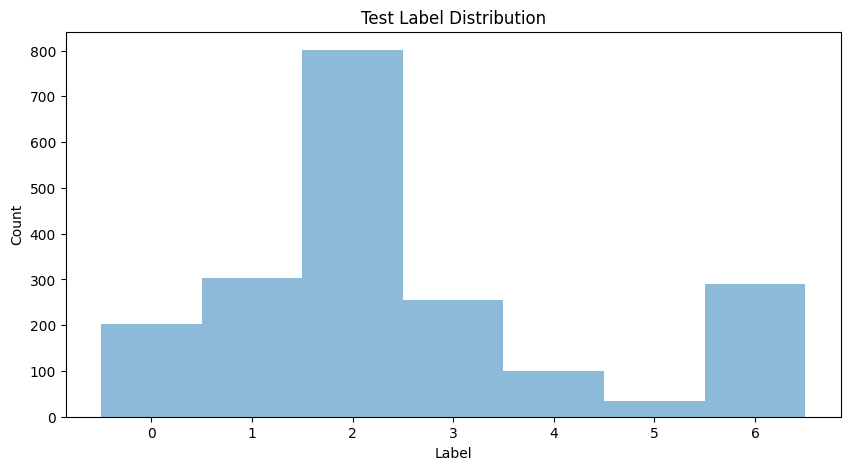

In [9]:

import matplotlib.pyplot as plt


# Plot the distribution of train labels
bins = np.arange(0, 6 + 2) - 0.5

plt.figure(figsize=(10, 5))
plt.hist(val_preds, bins=bins, alpha=0.5)
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(np.arange(0, 6 + 1))
plt.title("Test Label Distribution")
plt.show()


In [11]:
# Extract features and labels for training dataset
train_features = feature_matrix[train_indices0]
train_labels = labels


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [12]:
from bayes_opt import BayesianOptimization

def wrapper_function():
    best_model_state_bay = None
    best_val_accuracy_bay = -1

    def objective_func(learning_rate, weight_decay, hidden_size, dropout, optimizer_idx):
        nonlocal best_model_state_bay, best_val_accuracy_bay

        optimizer_list = ['Adam', 'SGD', 'RMSprop']
        hyperparams = {
            'learning_rate': learning_rate,
            'weight_decay': weight_decay,
            'hidden_size': int(hidden_size),
            'optimizer': optimizer_list[int(optimizer_idx)],
            'dropout': dropout
        }
        val_accuracy, model_state = train_evaluate(hyperparams, graph, in_feats, num_classes, train_mask, val_mask, class_weights)

        if val_accuracy > best_val_accuracy_bay:
            best_val_accuracy_bay = val_accuracy
            best_model_state_bay = model_state

        return val_accuracy

    # Define the search space
    pbounds = {
        'learning_rate': (0.001, 0.2),
        'weight_decay': (1e-5,1e-4),
        'hidden_size': (32, 128),
        'dropout': (0.0, 0.75),
        'optimizer_idx': (0, 2)
    }

    # Run Bayesian optimization
    opt = BayesianOptimization(
        f=objective_func,
        pbounds=pbounds,
        random_state=42,
        verbose=0  # Set verbose to 0 to avoid printing intermediate results
    )
    n_iter = 20
    opt.maximize(init_points=5, n_iter=n_iter)

    return opt, best_model_state_bay

opt, best_model_bay = wrapper_function()

Epoch 1, Loss: 2.2652, Train Accuracy: 0.5960, Val Accuracy: 0.4500
Epoch 2, Loss: 1.1446, Train Accuracy: 0.6313, Val Accuracy: 0.4800
Epoch 3, Loss: 0.9027, Train Accuracy: 0.6162, Val Accuracy: 0.4400
Epoch 4, Loss: 0.8250, Train Accuracy: 0.5934, Val Accuracy: 0.4200
Epoch 5, Loss: 0.7450, Train Accuracy: 0.5682, Val Accuracy: 0.3900
Epoch 6, Loss: 0.6921, Train Accuracy: 0.5581, Val Accuracy: 0.3900
Epoch 7, Loss: 0.6412, Train Accuracy: 0.5556, Val Accuracy: 0.3800
Epoch 8, Loss: 0.6088, Train Accuracy: 0.5530, Val Accuracy: 0.3800
Epoch 9, Loss: 0.5716, Train Accuracy: 0.5707, Val Accuracy: 0.3800
Epoch 10, Loss: 0.5597, Train Accuracy: 0.5909, Val Accuracy: 0.4200
Epoch 11, Loss: 0.5243, Train Accuracy: 0.6136, Val Accuracy: 0.4400
Epoch 12, Loss: 0.5299, Train Accuracy: 0.6364, Val Accuracy: 0.4700
Epoch 13, Loss: 0.4943, Train Accuracy: 0.6818, Val Accuracy: 0.4800
Epoch 14, Loss: 0.4493, Train Accuracy: 0.7071, Val Accuracy: 0.4800
Epoch 15, Loss: 0.4551, Train Accuracy: 0.7

c:\Users\Aditya\anaconda3\envs\gnn\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 1, Loss: 2.5329, Train Accuracy: 0.4545, Val Accuracy: 0.3700
Epoch 2, Loss: 0.9850, Train Accuracy: 0.6667, Val Accuracy: 0.5400
Epoch 3, Loss: 0.7556, Train Accuracy: 0.6793, Val Accuracy: 0.5700
Epoch 4, Loss: 0.6606, Train Accuracy: 0.6919, Val Accuracy: 0.6000
Epoch 5, Loss: 0.5547, Train Accuracy: 0.7172, Val Accuracy: 0.6200
Epoch 6, Loss: 0.4757, Train Accuracy: 0.7449, Val Accuracy: 0.6300
Epoch 7, Loss: 0.3960, Train Accuracy: 0.7753, Val Accuracy: 0.6500
Epoch 8, Loss: 0.3350, Train Accuracy: 0.7904, Val Accuracy: 0.6700
Epoch 9, Loss: 0.2860, Train Accuracy: 0.8283, Val Accuracy: 0.6800
Epoch 10, Loss: 0.2487, Train Accuracy: 0.8510, Val Accuracy: 0.6900
Epoch 11, Loss: 0.2135, Train Accuracy: 0.8687, Val Accuracy: 0.7500
Epoch 12, Loss: 0.1923, Train Accuracy: 0.8864, Val Accuracy: 0.7500
Epoch 13, Loss: 0.1656, Train Accuracy: 0.8990, Val Accuracy: 0.7500
Epoch 14, Loss: 0.1435, Train Accuracy: 0.9116, Val Accuracy: 0.7500
Epoch 15, Loss: 0.1383, Train Accuracy: 0.9

c:\Users\Aditya\anaconda3\envs\gnn\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 1, Loss: 2.3315, Train Accuracy: 0.6465, Val Accuracy: 0.6400
Epoch 2, Loss: 0.7561, Train Accuracy: 0.6490, Val Accuracy: 0.5600
Epoch 3, Loss: 0.5718, Train Accuracy: 0.6970, Val Accuracy: 0.5500
Epoch 4, Loss: 0.4821, Train Accuracy: 0.7121, Val Accuracy: 0.5800
Epoch 5, Loss: 0.4131, Train Accuracy: 0.7222, Val Accuracy: 0.5800
Epoch 6, Loss: 0.3499, Train Accuracy: 0.6894, Val Accuracy: 0.5500
Epoch 7, Loss: 0.2992, Train Accuracy: 0.6894, Val Accuracy: 0.5400
Epoch 8, Loss: 0.2582, Train Accuracy: 0.7096, Val Accuracy: 0.5500
Epoch 9, Loss: 0.2219, Train Accuracy: 0.7601, Val Accuracy: 0.6000
Epoch 10, Loss: 0.1903, Train Accuracy: 0.8232, Val Accuracy: 0.6100
Epoch 11, Loss: 0.1636, Train Accuracy: 0.8712, Val Accuracy: 0.6300
Epoch 12, Loss: 0.1415, Train Accuracy: 0.9242, Val Accuracy: 0.6800
Epoch 13, Loss: 0.1230, Train Accuracy: 0.9318, Val Accuracy: 0.7200
Epoch 14, Loss: 0.1073, Train Accuracy: 0.9596, Val Accuracy: 0.7200
Epoch 15, Loss: 0.0939, Train Accuracy: 0.9

c:\Users\Aditya\anaconda3\envs\gnn\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 1, Loss: 2.1363, Train Accuracy: 0.2652, Val Accuracy: 0.1700
Epoch 2, Loss: 1.5551, Train Accuracy: 0.4040, Val Accuracy: 0.2700
Epoch 3, Loss: 1.2528, Train Accuracy: 0.3763, Val Accuracy: 0.2600
Epoch 4, Loss: 1.0805, Train Accuracy: 0.3207, Val Accuracy: 0.2400
Epoch 5, Loss: 0.9772, Train Accuracy: 0.2828, Val Accuracy: 0.2100
Epoch 6, Loss: 0.9072, Train Accuracy: 0.2551, Val Accuracy: 0.1800
Epoch 7, Loss: 0.8437, Train Accuracy: 0.2500, Val Accuracy: 0.1800
Epoch 8, Loss: 0.8066, Train Accuracy: 0.2500, Val Accuracy: 0.1900
Epoch 9, Loss: 0.7713, Train Accuracy: 0.2576, Val Accuracy: 0.1900
Epoch 10, Loss: 0.7296, Train Accuracy: 0.2652, Val Accuracy: 0.2000
Epoch 11, Loss: 0.6986, Train Accuracy: 0.2854, Val Accuracy: 0.2200
Epoch 12, Loss: 0.6778, Train Accuracy: 0.2955, Val Accuracy: 0.2400
Epoch 13, Loss: 0.6539, Train Accuracy: 0.3081, Val Accuracy: 0.2400
Epoch 14, Loss: 0.6375, Train Accuracy: 0.3308, Val Accuracy: 0.2400
Epoch 15, Loss: 0.6130, Train Accuracy: 0.3

c:\Users\Aditya\anaconda3\envs\gnn\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 1, Loss: 2.3712, Train Accuracy: 0.8611, Val Accuracy: 0.7300
Epoch 2, Loss: 0.6543, Train Accuracy: 0.9116, Val Accuracy: 0.7800
Epoch 3, Loss: 0.5398, Train Accuracy: 0.9217, Val Accuracy: 0.7700
Epoch 4, Loss: 0.4688, Train Accuracy: 0.9293, Val Accuracy: 0.7300
Epoch 5, Loss: 0.4122, Train Accuracy: 0.9293, Val Accuracy: 0.7500
Epoch 6, Loss: 0.3737, Train Accuracy: 0.9318, Val Accuracy: 0.7700
Epoch 7, Loss: 0.3385, Train Accuracy: 0.9318, Val Accuracy: 0.7900
Epoch 8, Loss: 0.3073, Train Accuracy: 0.9369, Val Accuracy: 0.7900
Epoch 9, Loss: 0.2795, Train Accuracy: 0.9495, Val Accuracy: 0.8000
Epoch 10, Loss: 0.2687, Train Accuracy: 0.9596, Val Accuracy: 0.8100
Epoch 11, Loss: 0.2380, Train Accuracy: 0.9672, Val Accuracy: 0.8000
Epoch 12, Loss: 0.2236, Train Accuracy: 0.9722, Val Accuracy: 0.8100
Epoch 13, Loss: 0.2014, Train Accuracy: 0.9798, Val Accuracy: 0.8000
Epoch 14, Loss: 0.1816, Train Accuracy: 0.9798, Val Accuracy: 0.7900
Epoch 15, Loss: 0.1754, Train Accuracy: 0.9

c:\Users\Aditya\anaconda3\envs\gnn\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 1, Loss: 2.2801, Train Accuracy: 0.5000, Val Accuracy: 0.4100
Epoch 2, Loss: 0.8306, Train Accuracy: 0.6641, Val Accuracy: 0.6600
Epoch 3, Loss: 0.6194, Train Accuracy: 0.6944, Val Accuracy: 0.6300
Epoch 4, Loss: 0.5378, Train Accuracy: 0.7374, Val Accuracy: 0.6700
Epoch 5, Loss: 0.4562, Train Accuracy: 0.7652, Val Accuracy: 0.6800
Epoch 6, Loss: 0.3869, Train Accuracy: 0.7803, Val Accuracy: 0.6900
Epoch 7, Loss: 0.3327, Train Accuracy: 0.8056, Val Accuracy: 0.7200
Epoch 8, Loss: 0.2851, Train Accuracy: 0.8384, Val Accuracy: 0.7300
Epoch 9, Loss: 0.2451, Train Accuracy: 0.8535, Val Accuracy: 0.7500
Epoch 10, Loss: 0.2103, Train Accuracy: 0.8636, Val Accuracy: 0.7700
Epoch 11, Loss: 0.1811, Train Accuracy: 0.8965, Val Accuracy: 0.7700
Epoch 12, Loss: 0.1562, Train Accuracy: 0.9040, Val Accuracy: 0.7800
Epoch 13, Loss: 0.1360, Train Accuracy: 0.9242, Val Accuracy: 0.7800
Epoch 14, Loss: 0.1181, Train Accuracy: 0.9369, Val Accuracy: 0.7700
Epoch 15, Loss: 0.1044, Train Accuracy: 0.9

c:\Users\Aditya\anaconda3\envs\gnn\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 1, Loss: 2.2175, Train Accuracy: 0.8359, Val Accuracy: 0.6900
Epoch 2, Loss: 0.6176, Train Accuracy: 0.8586, Val Accuracy: 0.7300
Epoch 3, Loss: 0.5109, Train Accuracy: 0.8561, Val Accuracy: 0.7000
Epoch 4, Loss: 0.4384, Train Accuracy: 0.8535, Val Accuracy: 0.7100
Epoch 5, Loss: 0.3865, Train Accuracy: 0.8687, Val Accuracy: 0.7100
Epoch 6, Loss: 0.3381, Train Accuracy: 0.8990, Val Accuracy: 0.7600
Epoch 7, Loss: 0.3036, Train Accuracy: 0.9167, Val Accuracy: 0.7500
Epoch 8, Loss: 0.2708, Train Accuracy: 0.9343, Val Accuracy: 0.7600
Epoch 9, Loss: 0.2379, Train Accuracy: 0.9394, Val Accuracy: 0.7600
Epoch 10, Loss: 0.2136, Train Accuracy: 0.9495, Val Accuracy: 0.7600
Epoch 11, Loss: 0.1953, Train Accuracy: 0.9495, Val Accuracy: 0.7700
Epoch 12, Loss: 0.1781, Train Accuracy: 0.9520, Val Accuracy: 0.7600
Epoch 13, Loss: 0.1580, Train Accuracy: 0.9621, Val Accuracy: 0.7700
Epoch 14, Loss: 0.1422, Train Accuracy: 0.9672, Val Accuracy: 0.7700
Epoch 15, Loss: 0.1306, Train Accuracy: 0.9

c:\Users\Aditya\anaconda3\envs\gnn\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 2, Loss: 0.8274, Train Accuracy: 0.8409, Val Accuracy: 0.6900
Epoch 3, Loss: 0.6150, Train Accuracy: 0.8056, Val Accuracy: 0.7200
Epoch 4, Loss: 0.5367, Train Accuracy: 0.7929, Val Accuracy: 0.7400
Epoch 5, Loss: 0.4713, Train Accuracy: 0.8207, Val Accuracy: 0.7600
Epoch 6, Loss: 0.4059, Train Accuracy: 0.8535, Val Accuracy: 0.7800
Epoch 7, Loss: 0.3493, Train Accuracy: 0.8889, Val Accuracy: 0.8000
Epoch 8, Loss: 0.3010, Train Accuracy: 0.8990, Val Accuracy: 0.8300
Epoch 9, Loss: 0.2590, Train Accuracy: 0.9141, Val Accuracy: 0.8300
Epoch 10, Loss: 0.2284, Train Accuracy: 0.9268, Val Accuracy: 0.8300
Epoch 11, Loss: 0.1951, Train Accuracy: 0.9369, Val Accuracy: 0.8100
Epoch 12, Loss: 0.1726, Train Accuracy: 0.9444, Val Accuracy: 0.8100
Epoch 13, Loss: 0.1497, Train Accuracy: 0.9444, Val Accuracy: 0.8000
Epoch 14, Loss: 0.1309, Train Accuracy: 0.9520, Val Accuracy: 0.8000
Epoch 15, Loss: 0.1150, Train Accuracy: 0.9520, Val Accuracy: 0.8000
Epoch 16, Loss: 0.1026, Train Accuracy: 0.

c:\Users\Aditya\anaconda3\envs\gnn\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 1, Loss: 2.2276, Train Accuracy: 0.3333, Val Accuracy: 0.3100
Epoch 2, Loss: 0.9366, Train Accuracy: 0.4495, Val Accuracy: 0.3700
Epoch 3, Loss: 0.6687, Train Accuracy: 0.5202, Val Accuracy: 0.4300
Epoch 4, Loss: 0.5736, Train Accuracy: 0.6212, Val Accuracy: 0.5200
Epoch 5, Loss: 0.4901, Train Accuracy: 0.7500, Val Accuracy: 0.6000
Epoch 6, Loss: 0.4067, Train Accuracy: 0.8081, Val Accuracy: 0.6100
Epoch 7, Loss: 0.3414, Train Accuracy: 0.8434, Val Accuracy: 0.6900
Epoch 8, Loss: 0.2927, Train Accuracy: 0.8788, Val Accuracy: 0.7500
Epoch 9, Loss: 0.2542, Train Accuracy: 0.8965, Val Accuracy: 0.7500
Epoch 10, Loss: 0.2172, Train Accuracy: 0.9040, Val Accuracy: 0.7700
Epoch 11, Loss: 0.1914, Train Accuracy: 0.9091, Val Accuracy: 0.8000
Epoch 12, Loss: 0.1657, Train Accuracy: 0.9242, Val Accuracy: 0.8200
Epoch 13, Loss: 0.1472, Train Accuracy: 0.9419, Val Accuracy: 0.8300
Epoch 14, Loss: 0.1339, Train Accuracy: 0.9444, Val Accuracy: 0.8300
Epoch 15, Loss: 0.1175, Train Accuracy: 0.9

c:\Users\Aditya\anaconda3\envs\gnn\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 1, Loss: 2.4463, Train Accuracy: 0.4874, Val Accuracy: 0.4800
Epoch 2, Loss: 1.1119, Train Accuracy: 0.6338, Val Accuracy: 0.5600
Epoch 3, Loss: 0.8195, Train Accuracy: 0.7879, Val Accuracy: 0.7300
Epoch 4, Loss: 0.6923, Train Accuracy: 0.8460, Val Accuracy: 0.7500
Epoch 5, Loss: 0.6003, Train Accuracy: 0.8763, Val Accuracy: 0.7400
Epoch 6, Loss: 0.5007, Train Accuracy: 0.8939, Val Accuracy: 0.7600
Epoch 7, Loss: 0.4626, Train Accuracy: 0.9192, Val Accuracy: 0.7700
Epoch 8, Loss: 0.3701, Train Accuracy: 0.9268, Val Accuracy: 0.7900
Epoch 9, Loss: 0.3342, Train Accuracy: 0.9268, Val Accuracy: 0.8100
Epoch 10, Loss: 0.2914, Train Accuracy: 0.9318, Val Accuracy: 0.8100
Epoch 11, Loss: 0.2557, Train Accuracy: 0.9394, Val Accuracy: 0.8200
Epoch 12, Loss: 0.2244, Train Accuracy: 0.9444, Val Accuracy: 0.8200
Epoch 13, Loss: 0.2018, Train Accuracy: 0.9444, Val Accuracy: 0.8300
Epoch 14, Loss: 0.1867, Train Accuracy: 0.9520, Val Accuracy: 0.8400
Epoch 15, Loss: 0.1715, Train Accuracy: 0.9

c:\Users\Aditya\anaconda3\envs\gnn\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 2, Loss: 0.7112, Train Accuracy: 0.7854, Val Accuracy: 0.6600
Epoch 3, Loss: 0.5467, Train Accuracy: 0.7677, Val Accuracy: 0.6600
Epoch 4, Loss: 0.4774, Train Accuracy: 0.7551, Val Accuracy: 0.5900
Epoch 5, Loss: 0.4162, Train Accuracy: 0.7652, Val Accuracy: 0.5500
Epoch 6, Loss: 0.3712, Train Accuracy: 0.7753, Val Accuracy: 0.5600
Epoch 7, Loss: 0.3218, Train Accuracy: 0.7854, Val Accuracy: 0.5500
Epoch 8, Loss: 0.2824, Train Accuracy: 0.8005, Val Accuracy: 0.5700
Epoch 9, Loss: 0.2449, Train Accuracy: 0.8333, Val Accuracy: 0.5700
Epoch 10, Loss: 0.2140, Train Accuracy: 0.8636, Val Accuracy: 0.5800
Epoch 11, Loss: 0.1934, Train Accuracy: 0.8712, Val Accuracy: 0.5900
Epoch 12, Loss: 0.1639, Train Accuracy: 0.8939, Val Accuracy: 0.6200
Epoch 13, Loss: 0.1458, Train Accuracy: 0.9192, Val Accuracy: 0.6500
Epoch 14, Loss: 0.1261, Train Accuracy: 0.9394, Val Accuracy: 0.6700
Epoch 15, Loss: 0.1159, Train Accuracy: 0.9444, Val Accuracy: 0.6800
Epoch 16, Loss: 0.1032, Train Accuracy: 0.

c:\Users\Aditya\anaconda3\envs\gnn\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 1, Loss: 2.4183, Train Accuracy: 0.1768, Val Accuracy: 0.1400
Epoch 2, Loss: 2.1310, Train Accuracy: 0.1919, Val Accuracy: 0.1800
Epoch 3, Loss: 2.0031, Train Accuracy: 0.2071, Val Accuracy: 0.1500
Epoch 4, Loss: 1.8447, Train Accuracy: 0.2475, Val Accuracy: 0.2000
Epoch 5, Loss: 1.6736, Train Accuracy: 0.2576, Val Accuracy: 0.1900
Epoch 6, Loss: 1.6088, Train Accuracy: 0.2500, Val Accuracy: 0.1900
Epoch 7, Loss: 1.4911, Train Accuracy: 0.2652, Val Accuracy: 0.2300
Epoch 8, Loss: 1.4218, Train Accuracy: 0.2803, Val Accuracy: 0.2400
Epoch 9, Loss: 1.3243, Train Accuracy: 0.3157, Val Accuracy: 0.2600
Epoch 10, Loss: 1.2447, Train Accuracy: 0.3283, Val Accuracy: 0.2600
Epoch 11, Loss: 1.2374, Train Accuracy: 0.3485, Val Accuracy: 0.2900
Epoch 12, Loss: 1.1692, Train Accuracy: 0.3662, Val Accuracy: 0.3100
Epoch 13, Loss: 1.1258, Train Accuracy: 0.3788, Val Accuracy: 0.3300
Epoch 14, Loss: 1.0972, Train Accuracy: 0.4040, Val Accuracy: 0.3400
Epoch 15, Loss: 1.0709, Train Accuracy: 0.4

c:\Users\Aditya\anaconda3\envs\gnn\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 2, Loss: 1.3725, Train Accuracy: 0.5808, Val Accuracy: 0.4800
Epoch 3, Loss: 1.0658, Train Accuracy: 0.4697, Val Accuracy: 0.4200
Epoch 4, Loss: 0.9472, Train Accuracy: 0.3990, Val Accuracy: 0.3400
Epoch 5, Loss: 0.8581, Train Accuracy: 0.3662, Val Accuracy: 0.3100
Epoch 6, Loss: 0.7861, Train Accuracy: 0.3510, Val Accuracy: 0.3200
Epoch 7, Loss: 0.7663, Train Accuracy: 0.3460, Val Accuracy: 0.3100
Epoch 8, Loss: 0.7194, Train Accuracy: 0.3384, Val Accuracy: 0.3100
Epoch 9, Loss: 0.6785, Train Accuracy: 0.3359, Val Accuracy: 0.3000
Epoch 10, Loss: 0.6546, Train Accuracy: 0.3359, Val Accuracy: 0.2900
Epoch 11, Loss: 0.6087, Train Accuracy: 0.3434, Val Accuracy: 0.3000
Epoch 12, Loss: 0.5891, Train Accuracy: 0.3561, Val Accuracy: 0.3000
Epoch 13, Loss: 0.5705, Train Accuracy: 0.3662, Val Accuracy: 0.3000
Epoch 14, Loss: 0.5437, Train Accuracy: 0.3788, Val Accuracy: 0.3200
Epoch 15, Loss: 0.5356, Train Accuracy: 0.3838, Val Accuracy: 0.3300
Epoch 16, Loss: 0.5096, Train Accuracy: 0.

c:\Users\Aditya\anaconda3\envs\gnn\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 1, Loss: 2.3424, Train Accuracy: 0.7551, Val Accuracy: 0.6900
Epoch 2, Loss: 0.8846, Train Accuracy: 0.7045, Val Accuracy: 0.6200
Epoch 3, Loss: 0.6678, Train Accuracy: 0.6944, Val Accuracy: 0.5900
Epoch 4, Loss: 0.5738, Train Accuracy: 0.7273, Val Accuracy: 0.5900
Epoch 5, Loss: 0.5052, Train Accuracy: 0.7727, Val Accuracy: 0.6000
Epoch 6, Loss: 0.4416, Train Accuracy: 0.8207, Val Accuracy: 0.6400
Epoch 7, Loss: 0.3738, Train Accuracy: 0.8586, Val Accuracy: 0.7000
Epoch 8, Loss: 0.3305, Train Accuracy: 0.8737, Val Accuracy: 0.7300
Epoch 9, Loss: 0.2845, Train Accuracy: 0.8939, Val Accuracy: 0.7400
Epoch 10, Loss: 0.2531, Train Accuracy: 0.9167, Val Accuracy: 0.7500
Epoch 11, Loss: 0.2136, Train Accuracy: 0.9242, Val Accuracy: 0.7700
Epoch 12, Loss: 0.1843, Train Accuracy: 0.9369, Val Accuracy: 0.7900
Epoch 13, Loss: 0.1583, Train Accuracy: 0.9444, Val Accuracy: 0.7700
Epoch 14, Loss: 0.1436, Train Accuracy: 0.9495, Val Accuracy: 0.7700
Epoch 15, Loss: 0.1222, Train Accuracy: 0.9

c:\Users\Aditya\anaconda3\envs\gnn\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 3, Loss: 0.7508, Train Accuracy: 0.7854, Val Accuracy: 0.7200
Epoch 4, Loss: 0.6393, Train Accuracy: 0.8182, Val Accuracy: 0.7400
Epoch 5, Loss: 0.5595, Train Accuracy: 0.8333, Val Accuracy: 0.7200
Epoch 6, Loss: 0.4882, Train Accuracy: 0.8636, Val Accuracy: 0.7500
Epoch 7, Loss: 0.4144, Train Accuracy: 0.8914, Val Accuracy: 0.7800
Epoch 8, Loss: 0.3504, Train Accuracy: 0.9015, Val Accuracy: 0.8300
Epoch 9, Loss: 0.3206, Train Accuracy: 0.9141, Val Accuracy: 0.8300
Epoch 10, Loss: 0.2851, Train Accuracy: 0.9192, Val Accuracy: 0.8300
Epoch 11, Loss: 0.2507, Train Accuracy: 0.9217, Val Accuracy: 0.8200
Epoch 12, Loss: 0.2325, Train Accuracy: 0.9293, Val Accuracy: 0.8200
Epoch 13, Loss: 0.2084, Train Accuracy: 0.9268, Val Accuracy: 0.8200
Epoch 14, Loss: 0.1874, Train Accuracy: 0.9268, Val Accuracy: 0.8200
Epoch 15, Loss: 0.1761, Train Accuracy: 0.9318, Val Accuracy: 0.8200
Epoch 16, Loss: 0.1609, Train Accuracy: 0.9495, Val Accuracy: 0.8200
Epoch 17, Loss: 0.1443, Train Accuracy: 0

c:\Users\Aditya\anaconda3\envs\gnn\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 1, Loss: 2.1627, Train Accuracy: 0.7500, Val Accuracy: 0.6800
Epoch 2, Loss: 0.6990, Train Accuracy: 0.7980, Val Accuracy: 0.6900
Epoch 3, Loss: 0.5804, Train Accuracy: 0.8131, Val Accuracy: 0.7100
Epoch 4, Loss: 0.4801, Train Accuracy: 0.8409, Val Accuracy: 0.7100
Epoch 5, Loss: 0.4196, Train Accuracy: 0.8737, Val Accuracy: 0.7200
Epoch 6, Loss: 0.3657, Train Accuracy: 0.8788, Val Accuracy: 0.7200
Epoch 7, Loss: 0.3237, Train Accuracy: 0.8965, Val Accuracy: 0.7200
Epoch 8, Loss: 0.2804, Train Accuracy: 0.9066, Val Accuracy: 0.7300
Epoch 9, Loss: 0.2391, Train Accuracy: 0.9167, Val Accuracy: 0.7400
Epoch 10, Loss: 0.2151, Train Accuracy: 0.9268, Val Accuracy: 0.7400
Epoch 11, Loss: 0.1870, Train Accuracy: 0.9394, Val Accuracy: 0.7500
Epoch 12, Loss: 0.1625, Train Accuracy: 0.9444, Val Accuracy: 0.7700
Epoch 13, Loss: 0.1469, Train Accuracy: 0.9596, Val Accuracy: 0.7800
Epoch 14, Loss: 0.1235, Train Accuracy: 0.9646, Val Accuracy: 0.7800
Epoch 15, Loss: 0.1189, Train Accuracy: 0.9

c:\Users\Aditya\anaconda3\envs\gnn\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 1, Loss: 2.3091, Train Accuracy: 0.5581, Val Accuracy: 0.5600
Epoch 2, Loss: 0.9138, Train Accuracy: 0.7500, Val Accuracy: 0.7400
Epoch 3, Loss: 0.7426, Train Accuracy: 0.8283, Val Accuracy: 0.7400
Epoch 4, Loss: 0.6123, Train Accuracy: 0.8460, Val Accuracy: 0.7500
Epoch 5, Loss: 0.5236, Train Accuracy: 0.8788, Val Accuracy: 0.7700
Epoch 6, Loss: 0.4515, Train Accuracy: 0.9091, Val Accuracy: 0.8100
Epoch 7, Loss: 0.3916, Train Accuracy: 0.9192, Val Accuracy: 0.8500
Epoch 8, Loss: 0.3416, Train Accuracy: 0.9293, Val Accuracy: 0.8600
Epoch 9, Loss: 0.2943, Train Accuracy: 0.9394, Val Accuracy: 0.8300
Epoch 10, Loss: 0.2631, Train Accuracy: 0.9520, Val Accuracy: 0.8300
Epoch 11, Loss: 0.2403, Train Accuracy: 0.9520, Val Accuracy: 0.8300
Epoch 12, Loss: 0.2008, Train Accuracy: 0.9495, Val Accuracy: 0.8300
Epoch 13, Loss: 0.1802, Train Accuracy: 0.9571, Val Accuracy: 0.8300
Epoch 14, Loss: 0.1597, Train Accuracy: 0.9545, Val Accuracy: 0.8300
Epoch 15, Loss: 0.1574, Train Accuracy: 0.9

c:\Users\Aditya\anaconda3\envs\gnn\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 3, Loss: 0.7337, Train Accuracy: 0.8131, Val Accuracy: 0.7200
Epoch 4, Loss: 0.6589, Train Accuracy: 0.8687, Val Accuracy: 0.7600
Epoch 5, Loss: 0.5648, Train Accuracy: 0.9015, Val Accuracy: 0.7700
Epoch 6, Loss: 0.5299, Train Accuracy: 0.9141, Val Accuracy: 0.8000
Epoch 7, Loss: 0.4573, Train Accuracy: 0.9293, Val Accuracy: 0.8100
Epoch 8, Loss: 0.4012, Train Accuracy: 0.9343, Val Accuracy: 0.8200
Epoch 9, Loss: 0.3960, Train Accuracy: 0.9369, Val Accuracy: 0.8300
Epoch 10, Loss: 0.3501, Train Accuracy: 0.9419, Val Accuracy: 0.8300
Epoch 11, Loss: 0.3242, Train Accuracy: 0.9470, Val Accuracy: 0.8400
Epoch 12, Loss: 0.2854, Train Accuracy: 0.9470, Val Accuracy: 0.8300
Epoch 13, Loss: 0.2628, Train Accuracy: 0.9470, Val Accuracy: 0.8300
Epoch 14, Loss: 0.2381, Train Accuracy: 0.9545, Val Accuracy: 0.8300
Epoch 15, Loss: 0.2091, Train Accuracy: 0.9596, Val Accuracy: 0.8400
Epoch 16, Loss: 0.1911, Train Accuracy: 0.9697, Val Accuracy: 0.8600
Epoch 17, Loss: 0.1812, Train Accuracy: 0

c:\Users\Aditya\anaconda3\envs\gnn\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 2, Loss: 0.7690, Train Accuracy: 0.8586, Val Accuracy: 0.7200
Epoch 3, Loss: 0.5771, Train Accuracy: 0.8005, Val Accuracy: 0.6500
Epoch 4, Loss: 0.4986, Train Accuracy: 0.7576, Val Accuracy: 0.6200
Epoch 5, Loss: 0.4297, Train Accuracy: 0.7601, Val Accuracy: 0.6100
Epoch 6, Loss: 0.3729, Train Accuracy: 0.7753, Val Accuracy: 0.6100
Epoch 7, Loss: 0.3195, Train Accuracy: 0.8106, Val Accuracy: 0.6700
Epoch 8, Loss: 0.2777, Train Accuracy: 0.8359, Val Accuracy: 0.7000
Epoch 9, Loss: 0.2384, Train Accuracy: 0.8586, Val Accuracy: 0.7400
Epoch 10, Loss: 0.2060, Train Accuracy: 0.8838, Val Accuracy: 0.7600
Epoch 11, Loss: 0.1805, Train Accuracy: 0.9116, Val Accuracy: 0.7600
Epoch 12, Loss: 0.1578, Train Accuracy: 0.9318, Val Accuracy: 0.7800
Epoch 13, Loss: 0.1355, Train Accuracy: 0.9596, Val Accuracy: 0.7800
Epoch 14, Loss: 0.1169, Train Accuracy: 0.9722, Val Accuracy: 0.7900
Epoch 15, Loss: 0.1041, Train Accuracy: 0.9722, Val Accuracy: 0.7700
Epoch 16, Loss: 0.0928, Train Accuracy: 0.

c:\Users\Aditya\anaconda3\envs\gnn\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 1, Loss: 2.1660, Train Accuracy: 0.7778, Val Accuracy: 0.6500
Epoch 2, Loss: 0.7944, Train Accuracy: 0.7753, Val Accuracy: 0.6700
Epoch 3, Loss: 0.6176, Train Accuracy: 0.8283, Val Accuracy: 0.7100
Epoch 4, Loss: 0.5312, Train Accuracy: 0.8586, Val Accuracy: 0.7300
Epoch 5, Loss: 0.4628, Train Accuracy: 0.8990, Val Accuracy: 0.7500
Epoch 6, Loss: 0.4141, Train Accuracy: 0.9343, Val Accuracy: 0.7600
Epoch 7, Loss: 0.3597, Train Accuracy: 0.9520, Val Accuracy: 0.8100
Epoch 8, Loss: 0.3300, Train Accuracy: 0.9646, Val Accuracy: 0.8000
Epoch 9, Loss: 0.2896, Train Accuracy: 0.9621, Val Accuracy: 0.7900
Epoch 10, Loss: 0.2503, Train Accuracy: 0.9571, Val Accuracy: 0.7900
Epoch 11, Loss: 0.2313, Train Accuracy: 0.9646, Val Accuracy: 0.8000
Epoch 12, Loss: 0.2032, Train Accuracy: 0.9722, Val Accuracy: 0.7900
Epoch 13, Loss: 0.1872, Train Accuracy: 0.9722, Val Accuracy: 0.8100
Epoch 14, Loss: 0.1655, Train Accuracy: 0.9722, Val Accuracy: 0.8000
Epoch 15, Loss: 0.1467, Train Accuracy: 0.9

c:\Users\Aditya\anaconda3\envs\gnn\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 1, Loss: 2.3927, Train Accuracy: 0.2753, Val Accuracy: 0.2800
Epoch 2, Loss: 2.0213, Train Accuracy: 0.4621, Val Accuracy: 0.4300
Epoch 3, Loss: 1.8040, Train Accuracy: 0.4975, Val Accuracy: 0.4700
Epoch 4, Loss: 1.5472, Train Accuracy: 0.5177, Val Accuracy: 0.4500
Epoch 5, Loss: 1.3546, Train Accuracy: 0.5606, Val Accuracy: 0.5100
Epoch 6, Loss: 1.2444, Train Accuracy: 0.5732, Val Accuracy: 0.5100
Epoch 7, Loss: 1.1384, Train Accuracy: 0.5808, Val Accuracy: 0.5100
Epoch 8, Loss: 1.0178, Train Accuracy: 0.6010, Val Accuracy: 0.5500
Epoch 9, Loss: 0.9794, Train Accuracy: 0.6338, Val Accuracy: 0.5700
Epoch 10, Loss: 0.8928, Train Accuracy: 0.6667, Val Accuracy: 0.6000
Epoch 11, Loss: 0.8779, Train Accuracy: 0.6919, Val Accuracy: 0.6300
Epoch 12, Loss: 0.8183, Train Accuracy: 0.7374, Val Accuracy: 0.6600
Epoch 13, Loss: 0.7797, Train Accuracy: 0.7652, Val Accuracy: 0.7000
Epoch 14, Loss: 0.7485, Train Accuracy: 0.7879, Val Accuracy: 0.7500
Epoch 15, Loss: 0.7378, Train Accuracy: 0.8

In [13]:
# Print the best hyperparameters
optimizer_list = ['Adam', 'SGD', 'RMSprop']
best_optimizer = optimizer_list[int(opt.max['params']['optimizer_idx'])]
print("Best hyperparameters:")
print(f"learning_rate: {opt.max['params']['learning_rate']}")
print(f"weight_decay: {opt.max['params']['weight_decay']}")
print(f"hidden_size: {int(opt.max['params']['hidden_size'])}")
print(f"optimizer: {best_optimizer}")
print(f"dropout: {opt.max['params']['dropout']}")
print(f"Best validation accuracy: {opt.max['target']}")

Best hyperparameters:
learning_rate: 0.16665608551928393
weight_decay: 2.636424704863906e-05
hidden_size: 125
optimizer: Adam
dropout: 0.015438370721851835
Best validation accuracy: 0.8600000143051147


In [14]:

torch.save(best_model_bay, "best_model_bay.pt")
torch.save(best_model_rand, "best_model_rand.pt")


In [15]:
def train_evaluate_final(hyperparams, graph, in_feats, num_classes, train_mask, val_mask, weights):
    hidden_size = hyperparams['hidden_size']
    learning_rate = hyperparams['learning_rate']
    weight_decay = hyperparams['weight_decay']
    optimizer_name = hyperparams['optimizer']
    dropout = hyperparams['dropout']

    model = GCN(in_feats, hidden_size, num_classes, dropout)
    loss_function = nn.CrossEntropyLoss(weights)

    if optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Training loop and early stopping
    num_epochs = 300
    best_val_accuracy = -1
    best_model_state = None
    num_epochs_without_improvement = 0
    
    for epoch in range(num_epochs):
        model.train()
        logits = model(graph, graph.ndata['features'])
        loss = loss_function(logits[train_mask], graph.ndata['label'][train_mask])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            logits = model(graph, graph.ndata['features'])
            train_accuracy = (logits[train_mask].argmax(dim=1) == graph.ndata['label'][train_mask]).float().mean().item()
            val_accuracy = (logits[val_mask].argmax(dim=1) == graph.ndata['label'][val_mask]).float().mean().item()

        print(f"Epoch {epoch + 1}, Loss: {loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Early stopping
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            # best_model_state = model.state_dict()
            best_model = model
            num_epochs_without_improvement = 0
        else:
            num_epochs_without_improvement += 1
            
    
    return best_val_accuracy, best_model



In [16]:
best_hyperparams = {'weight_decay': 0.0001, 'optimizer': 'Adam', 'learning_rate': 0.01, 'hidden_size': 32, 'dropout': 0.75}
final_val_accuracy, final_model_R = train_evaluate_final(best_hyperparams, graph, in_feats, num_classes, train_mask, val_mask, class_weights)
torch.save(final_model_R, "best_model_R.pt")

Epoch 1, Loss: 2.3555, Train Accuracy: 0.5354, Val Accuracy: 0.4700
Epoch 2, Loss: 1.5664, Train Accuracy: 0.6995, Val Accuracy: 0.6500
Epoch 3, Loss: 1.2944, Train Accuracy: 0.7854, Val Accuracy: 0.7200
Epoch 4, Loss: 1.0483, Train Accuracy: 0.8460, Val Accuracy: 0.7200
Epoch 5, Loss: 0.9261, Train Accuracy: 0.8813, Val Accuracy: 0.7600
Epoch 6, Loss: 0.8936, Train Accuracy: 0.8889, Val Accuracy: 0.7800
Epoch 7, Loss: 0.8215, Train Accuracy: 0.9091, Val Accuracy: 0.7800
Epoch 8, Loss: 0.7776, Train Accuracy: 0.9369, Val Accuracy: 0.7800
Epoch 9, Loss: 0.7785, Train Accuracy: 0.9394, Val Accuracy: 0.7900
Epoch 10, Loss: 0.7121, Train Accuracy: 0.9419, Val Accuracy: 0.8200
Epoch 11, Loss: 0.7339, Train Accuracy: 0.9444, Val Accuracy: 0.8300
Epoch 12, Loss: 0.6876, Train Accuracy: 0.9495, Val Accuracy: 0.8300
Epoch 13, Loss: 0.6646, Train Accuracy: 0.9495, Val Accuracy: 0.8300
Epoch 14, Loss: 0.6339, Train Accuracy: 0.9545, Val Accuracy: 0.8300
Epoch 15, Loss: 0.6628, Train Accuracy: 0.9

In [17]:
best_hyperparamsb = {'weight_decay': 2.636424704863906e-05, 'optimizer': 'Adam', 'learning_rate':  0.16665608551928393, 'hidden_size': 125, 'dropout': 0.015438370721851835}

final_val_accuracyb, final_model_B = train_evaluate_final(best_hyperparamsb, graph, in_feats, num_classes, train_mask, val_mask, class_weights)

torch.save(final_model_B, "best_model_B.pt")


Epoch 1, Loss: 2.2389, Train Accuracy: 0.5177, Val Accuracy: 0.4400
Epoch 2, Loss: 0.9241, Train Accuracy: 0.8131, Val Accuracy: 0.6400
Epoch 3, Loss: 0.6753, Train Accuracy: 0.8359, Val Accuracy: 0.7100
Epoch 4, Loss: 0.5723, Train Accuracy: 0.8510, Val Accuracy: 0.7100
Epoch 5, Loss: 0.4804, Train Accuracy: 0.8864, Val Accuracy: 0.7400
Epoch 6, Loss: 0.3931, Train Accuracy: 0.9015, Val Accuracy: 0.7800
Epoch 7, Loss: 0.3273, Train Accuracy: 0.9116, Val Accuracy: 0.8100
Epoch 8, Loss: 0.2747, Train Accuracy: 0.9293, Val Accuracy: 0.8200
Epoch 9, Loss: 0.2322, Train Accuracy: 0.9369, Val Accuracy: 0.8400
Epoch 10, Loss: 0.1975, Train Accuracy: 0.9520, Val Accuracy: 0.8300
Epoch 11, Loss: 0.1718, Train Accuracy: 0.9571, Val Accuracy: 0.8300
Epoch 12, Loss: 0.1467, Train Accuracy: 0.9596, Val Accuracy: 0.8400
Epoch 13, Loss: 0.1274, Train Accuracy: 0.9646, Val Accuracy: 0.8500
Epoch 14, Loss: 0.1134, Train Accuracy: 0.9747, Val Accuracy: 0.8500
Epoch 15, Loss: 0.0988, Train Accuracy: 0.9

In [11]:

# Predict labels for all nodes
best_model_fold.eval()
with torch.no_grad():
    test_logits = best_model_fold(graph, graph.ndata['features'])
    test_predictions = torch.argmax(test_logits[test_mask], dim=1).numpy()

# Save predictions to a file
# with open("submissiontest.txt", "w") as submission_file:
#     for prediction in test_predictions:
#         submission_file.write(str(prediction) + "\n")

print("Predictions saved to submission.txt")

Predictions saved to submission.txt


In [11]:
test_logits = best_model_fold(graph, graph.ndata['features'])

In [12]:
test_logits

tensor([[-0.2571, -2.0835, -0.7992,  ..., -2.2518,  4.2473,  0.9573],
        [-1.2256, -0.6475,  3.5039,  ..., -1.3514, -1.4848,  0.0793],
        [ 5.3364,  1.4798, -2.3538,  ..., -2.0898, -1.4575, -1.5615],
        ...,
        [-0.9749,  3.3089, -0.8499,  ..., -1.1695, -1.4294,  1.1509],
        [-1.8026,  0.6093,  1.0177,  ..., -1.8069, -2.5324,  4.1301],
        [-0.5089, -0.0567, -0.0496,  ..., -1.2457, -0.3575,  1.6171]],
       grad_fn=<NativeBatchNormBackward0>)

In [12]:
test_predictions

array([5, 2, 0, ..., 1, 6, 6], dtype=int64)

In [20]:
test_predictions


array([5, 2, 0, ..., 1, 6, 6], dtype=int64)

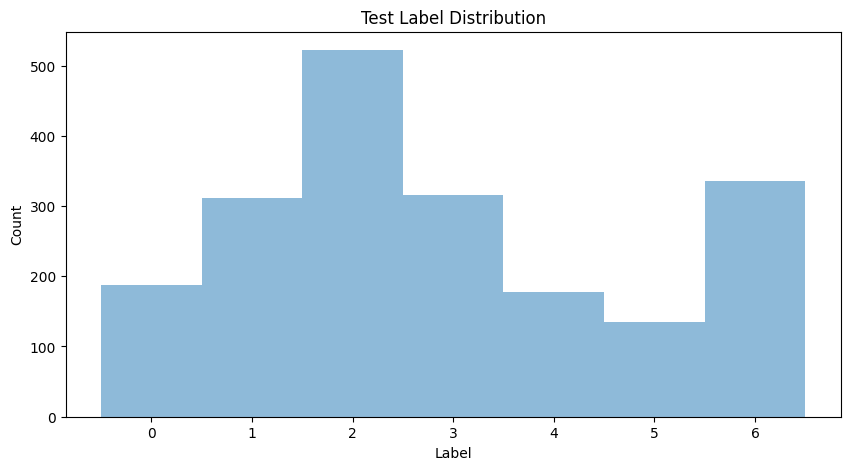

In [13]:

import matplotlib.pyplot as plt


# Plot the distribution of train labels
bins = np.arange(0, 6 + 2) - 0.5

plt.figure(figsize=(10, 5))
plt.hist(test_predictions, bins=bins, alpha=0.5)
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(np.arange(0, 6 + 1))
plt.title("Test Label Distribution")
plt.show()


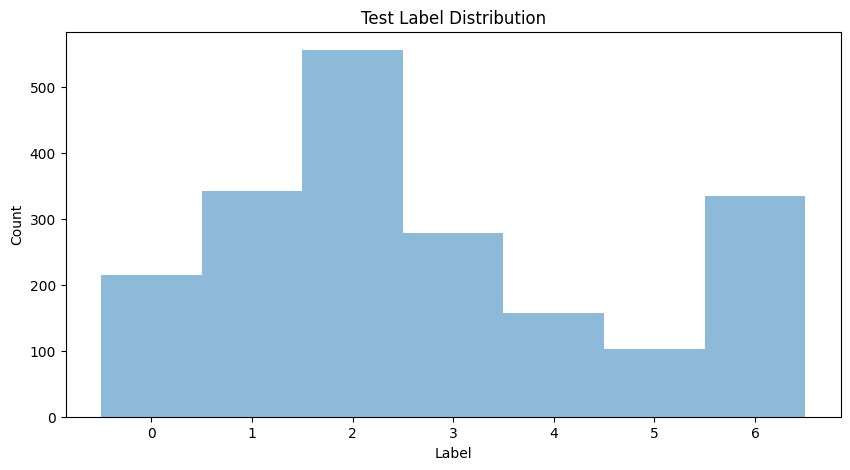

In [13]:

import matplotlib.pyplot as plt


# Plot the distribution of train labels
bins = np.arange(0, 6 + 2) - 0.5

plt.figure(figsize=(10, 5))
plt.hist(test_predictions, bins=bins, alpha=0.5)
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(np.arange(0, 6 + 1))
plt.title("Test Label Distribution")
plt.show()
